In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

#from scipy import misc
import imageio
import glob
from PIL import Image

from os import listdir
from os.path import isfile, join

import re

In [2]:
def get_patches_custom(img_arr, size=256, stride=256):
    """
    Takes single image or array of images and returns
    crops using sliding window method.
    If stride < size it will do overlapping.
    """   
     
    # check size and stride
    if size % stride != 0:
        raise ValueError("size % stride must be equal 0")

    patches_list = []
    overlapping = 0
    if stride != size:
        overlapping = (size // stride) - 1

    if img_arr.ndim == 3:
        i_max = img_arr.shape[0] // stride - overlapping
        j_max = img_arr.shape[1] // stride - overlapping
        for i in range(i_max):
            for j in range(j_max):
                patches_list.append(
                    img_arr[
                        i * stride : i * stride + size,
                        j * stride : j * stride + size
                    ]
                )

    elif img_arr.ndim == 4:
        i_max = img_arr.shape[1] // stride - overlapping
        for im in img_arr:
            for i in range(i_max):
                for j in range(i_max):
                    patches_list.append(
                        im[
                            i * stride : i * stride + size,
                            j * stride : j * stride + size,
                        ]
                    )

    else:
        raise ValueError("img_arr.ndim must be equal 3 or 4")

    return np.stack(patches_list)

In [ ]:
# Если надо переделать маски на черно-белые без зеленого

path_mask = "/Users/anastasia/Desktop/Нейросети/Project/train_val_masks_3cl/"
filename_mask = [f for f in listdir(path_mask) if isfile(join(path_mask, f)) and re.search('\d',f)]
filename_mask.sort()

for n in range(0,len(filename_mask)):
    print(n)
    mask = Image.open(path_mask + "/" + filename_mask[n])
    for i in range(mask.size[0]):
        for j in range(mask.size[1]):
            a = mask.getpixel((i, j))
            if a == (0, 255, 0) or a == (255, 0, 0):
                mask.putpixel((i, j), (255, 255, 255))
    mask.save(filename_mask[n]) 

In [3]:
def create_dataset(path_img, path_mask, crop_size):

    filename_img = [f for f in listdir(path_img) if isfile(join(path_img, f)) and re.search('\d',f)]
    filename_img.sort()
    filename_mask = [f for f in listdir(path_mask) if isfile(join(path_mask, f)) and re.search('\d',f)]
    filename_mask.sort()
    
    w_size = np.arange(0,len(filename_img))
    h_size = w_size.copy()
    n = 0
    x_crops_image = np.zeros((0, crop_size, crop_size, 3))
    x_crops_mask = np.zeros((0, crop_size, crop_size, 3))
    
    for n in range(0,len(filename_img)):
        print(n)
        print(filename_img[n])
        print(filename_mask[n])
        
        image = imageio.imread(path_img + "/" + filename_img[n])[:,:,0:3]
        print(image.shape)
        w_size[n] = image.shape[0]
        h_size[n] = image.shape[1]
        mask = imageio.imread(path_mask + "/" + filename_mask[n])[:,:,0:3]
        print(mask.shape)
        

        if  w_size[n] > h_size[n]:
            image = np.swapaxes(image,0,1)
            tmp = w_size[n]
            w_size[n] = h_size[n]
            h_size[n] = tmp
            
        x_crops = get_patches_custom(
            img_arr=image.astype(int), # required - array of images to be cropped
            size=crop_size, # default is 256
            stride=crop_size) # default is 256
        x_crops.astype(np.uint8)
        
        print(x_crops.shape)
        x_crops_image = np.append(x_crops_image, x_crops, axis=0)
        del(x_crops)
        
        x_crops = get_patches_custom(
            img_arr=mask.astype(int), # required - array of images to be cropped
            size=crop_size, # default is 256
            stride=crop_size) # default is 256
        x_crops.astype(np.uint8)
        
        print(x_crops.shape)
        x_crops_mask = np.append(x_crops_mask, x_crops, axis=0)
        del(x_crops)
        
    len_dataset = x_crops_image.shape[0]
    y_crops = np.zeros((len_dataset, 1))
            
    ind = np.argsort(y_crops, axis=0)
    x_crops_image[ind,:,:,:].shape
    x_sort = np.squeeze(x_crops_image[ind,:,:,:])
    y_sort = y_crops[ind].squeeze(axis=1)
    x_crops_mask[ind,:,:,:].shape
    x_sort_mask = np.squeeze(x_crops_mask[ind,:,:,:])
    
    return x_sort.astype(np.uint8), y_sort.astype(np.uint8), x_sort_mask.astype(np.uint8)

In [4]:
#from google.colab import drive
#drive.mount('/gdrive')
path_img = "/Users/anastasia/Desktop/Нейросети/Project/train_val_images/"
path_mask = "/Users/anastasia/Desktop/Нейросети/Project/train_val_masks/"
crop_size = 256

imgs_cropped, y_cropped, masks_cropped = create_dataset(path_img, path_mask, crop_size)


0
EVBH4-CH1A-2_0.20.tiff
EVBH4-CH1A-2_0.20.png
(8067, 9163, 3)
(8067, 9163, 3)
(1085, 256, 256, 3)
(1085, 256, 256, 3)
1
EVBH4-CH1A-4_0.20.tiff
EVBH4-CH1A-4_0.20.png
(7936, 9163, 3)
(7936, 9163, 3)
(1085, 256, 256, 3)
(1085, 256, 256, 3)
2
EVBH4-CH6B-0_0.20.tiff
EVBH4-CH6B-0_0.20.png
(8769, 9562, 3)
(8769, 9562, 3)
(1258, 256, 256, 3)
(1258, 256, 256, 3)


In [5]:
def plot_random_Images(images_arr, mask_arr, y):
    fig, axes = plt.subplots(2, 10, figsize=(20,5))
    axes = axes.flatten()
    rand_num = np.random.randint(0, len(y), size=10)
    
    print(rand_num)
    
    for k in range(0,10):
        axes[k].imshow(images_arr[rand_num[k]])
        axes[k+10].imshow(mask_arr[rand_num[k]])
        
    plt.tight_layout()
    plt.show()

[ 540  839 2515   80 2954 2501 2063  427 2528   92]


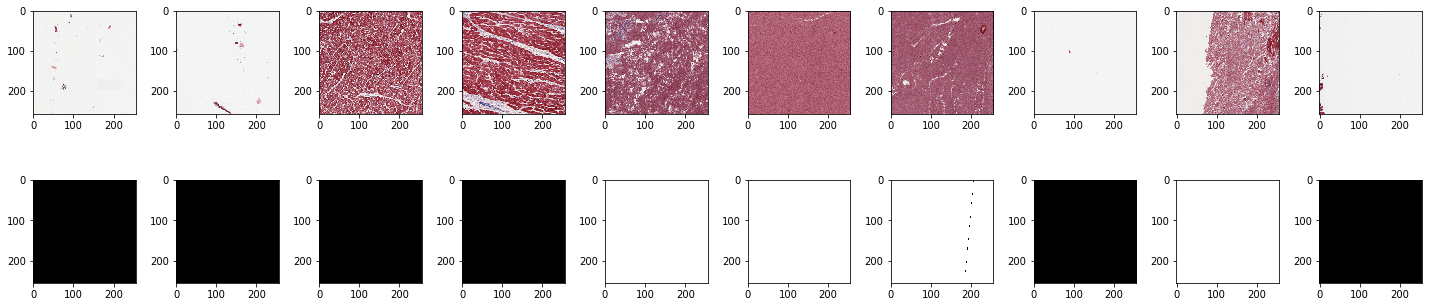

In [6]:
plot_random_Images(imgs_cropped, masks_cropped, y_cropped)

In [7]:
np.savez('train_val_cropped dataset_0804_wb', imgs_cropped, masks_cropped)